In [1]:
import numpy as np
import torch as th
import os
%load_ext autoreload
%autoreload 2
from PIL import Image 
from IPython.display import clear_output
from matplotlib.pyplot import imshow 
import matplotlib.pyplot as plt
import PIL
import torch

from itertools import islice
from torchvision.transforms.functional import to_tensor

import pandas as pd
from torchvision import transforms
from itertools import product
%matplotlib inline

# Add path to project 

In [2]:
import sys
sys.path
sys.path.append('/code/Deep-Vectorization-of-Technical-Drawings/')

In [3]:
from util_files.rendering.cairo  import render,render_with_skeleton
from util_files.data.graphics_primitives import PT_LINE,  PT_CBEZIER, PT_QBEZIER
import  util_files.loss_functions.supervised  as supervised_loss 
from util_files.optimization.optimizer.scheduled_optimizer import ScheduledOptimizer
import util_files.dataloading as dataloading
from vectorization import load_model
from util_files.patchify import patchify
from util_files.geometric import liang_barsky_screen
from util_files.rendering.cairo import render

# Parameters

In [4]:
device = torch.device('cuda:{}'.format(0))
prefetch_data = True
batches_completed_in_epoch=0
epoch_size = 20000
curve_count = 10
model_type = "model"

In [5]:
import sys; sys.argv=['']; del sys
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--output_dir', type=str, default="/logs/outputs/vectorization/curves/", help='dir to folder for output')
    parser.add_argument('--diff_render_it', type=int, default=200, help='iteration count')
    parser.add_argument('--init_random', action='store_true', default=False, dest='init_random',
                        help='init model with random [default: False].')
    parser.add_argument('--rendering_type', type=str, default='hard', help='hard -oleg,simple Alexey')
    parser.add_argument('--data_dir', type=str, default="/data/abc_png_svg/", help='dir to folder for input')
    parser.add_argument('--image_name', type=str, default="00050000_99fd5beca7714bc586260b6a_step_000.png",
                        help='Name of image.If None will perform to all images in '
                             'folder.[default: None]')
    parser.add_argument('--overlap', type=int, default=0, help='overlap in pixel')
    parser.add_argument('--model_output_count', type=int, default=10, help='max_model_output')
    
    return parser.parse_args()

In [6]:
options = parse_args()

# Read image/dataset

In [7]:
def preprocess_image(image):
    patch_height, patch_width = image.shape[1:3]
    image = torch.as_tensor(image).type(torch.float32).reshape(-1, patch_height, patch_width) / 255
    image = 1 - image  # 0 -- background
    mask = (image > 0).type(torch.float32)
    _xs = np.arange(1, patch_width + 1, dtype=np.float32)[None].repeat(patch_height, 0) / patch_width
    _ys = np.arange(1, patch_height + 1, dtype=np.float32)[..., None].repeat(patch_width, 1) / patch_height
    _xs = torch.from_numpy(_xs)[None]
    _ys = torch.from_numpy(_ys)[None]
    return torch.stack([image, _xs * mask, _ys * mask], dim=1)

In [8]:
def read_data(options, image_type = 'RGB'):
    train_transform = transforms.Compose([
        # something wrong with current model in vertical lines add random rotate if you need results too be better
#         transforms.RandomRotation(degrees = (2,5),fill=255),
        transforms.ToTensor(),
    ])
    dataset = []
    if options.image_name is None:
        image_names = os.listdir(options.data_dir)
        print(image_names)
        for image_name in image_names:
            if (image_name[-4:] != 'jpeg' and image_name[-3:] != 'png' and image_name[-3:] != 'jpg') or image_name[0]=='.':
                print(image_name[-4:])
                continue
            
            img = train_transform(Image.open(options.data_dir + image_name).convert(image_type))
            print(img.shape)
            img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                               img.shape[2] + (32 - img.shape[2] % 32))
            img_t[:, :img.shape[1], :img.shape[2]] = img
            dataset.append(img_t)
        options.image_name = image_names
    else:
        img = train_transform(Image.open(options.data_dir + options.image_name).convert(image_type))
        print(img)
        print(img.shape)
        img_t = torch.ones(img.shape[0], img.shape[1] + (32 - img.shape[1] % 32),
                           img.shape[2] + (32 - img.shape[2] % 32))
        img_t[:, :img.shape[1], :img.shape[2]] = img
        dataset.append(img_t)
        options.image_name = [options.image_name]

    return dataset

In [9]:
# options.image_name = options.image_name[0]
images = read_data(options,image_type='L')

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
torch.Size([1, 2220, 2652])


In [10]:
options.sample_name=options.image_name[0]

In [11]:
images[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [12]:
image = images[0]

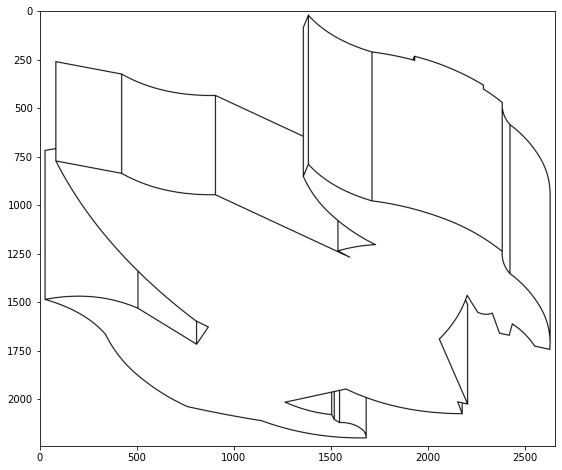

In [13]:
plt.figure(figsize=(12,8))
plt.imshow(image[0],'gray')

In [14]:
image

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# Model loading 

In [15]:
# in json file you can chose model type and it's parameters as in examples in vectorization/models/specs/ folder

In [16]:
# chose json file 
model_json_param = '/code/Deep-Vectorization-of-Technical-Drawings/vectorization/models/specs/resnet18_blocks1_bn_64__c2h__trans_heads4_feat256_blocks8_ffmaps512__h2o__out512.json'
#load/create model 
model = load_model(model_json_param).to(device)

In [18]:
def serialize(checkpoint):
    model_state_dict = checkpoint['model_state_dict']
    keys = []
    for k in model_state_dict:
        if 'hidden.transformer' in k:
            keys.append(k)

    for k in keys:
        new_key = 'hidden.decoder.transformer' + k[len('hidden.transformer'):]
        model_state_dict[new_key] = model_state_dict[k]
        del model_state_dict[k]
    return checkpoint
checkpoint = serialize(torch.load("/logs/models/vectorization/curves/model_curves.weights"))


model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Estimation of primitive 

In [19]:
def split_to_patches(rgb, patch_size, overlap=0):
    """Separates the input into square patches of specified size.

    :param rgb: input RGB image
    :type rgb: numpy.ndarray
    :param patch_size: size of patches in pixels (assuming
                        square patches)
    :type patch_size: int
    :param overlap: amount in pixels of how much the patches
                    can overlap with each other (useful for merging)
    :type overlap: int

    :returns patches, patches_offsets
    :rtype Tuple[numpy.ndarray, numpy.ndarray]
    """
    rgb = rgb.transpose(1, 2, 0)
    rgb_t = np.ones((rgb.shape[0] + 33, rgb.shape[1] + 33, rgb.shape[2])) * 255.
    rgb_t[:rgb.shape[0], :rgb.shape[1], :] = rgb
    rgb = rgb_t

    height, width, channels = rgb.shape

    assert patch_size > 0 and 0 <= overlap < patch_size
    patches = patchify(rgb,
                       patch_size=(patch_size, patch_size, channels),
                       step=patch_size - overlap)
    patches = patches.reshape((-1, patch_size, patch_size, channels))
    height_offsets = np.arange(0, height - patch_size, step=patch_size - overlap)
    width_offsets = np.arange(0, width - patch_size, step=patch_size - overlap)
    patches_offsets = np.array(list(
        product(height_offsets, width_offsets)
    ))
    return patches, patches_offsets, rgb

In [20]:
image_tensor = image.unsqueeze(0).to(device)
patches_rgb, patches_offsets, input_rgb = split_to_patches(image_tensor.cpu().numpy()[0] * 255, 64, options.overlap)

In [21]:
model.eval()
patches_vector = []
print('--- Preprocessing BEGIN')
patch_images = preprocess_image(patches_rgb)
print('--- Preprocessing END')

for it_batches in range(400, patch_images.shape[0] + 399, 400):
    it_start = it_batches - 400
    if it_batches > patch_images.shape[0]:
        it_batches = patch_images.shape[0]
    with torch.no_grad():
        if(it_start==0):
            patches_vector = model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()
        else:
            patches_vector = np.concatenate((patches_vector,model(patch_images[it_start:it_batches].cuda().float(), options.model_output_count).detach().cpu().numpy()),axis=0)
patches_vector = torch.tensor(patches_vector) * 64

--- Preprocessing BEGIN
--- Preprocessing END


In [22]:
patches_vector.shape

torch.Size([1470, 10, 8])

In [23]:
a ={PT_QBEZIER:patches_vector[200]}
rendered_image = render(a,(64,64), data_representation='vahe',linecaps='round')

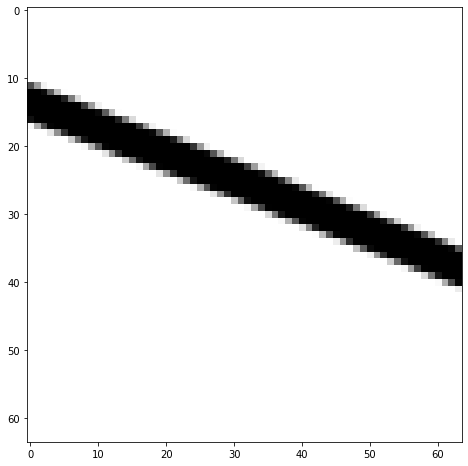

In [24]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

In [25]:
def assemble_vector_patches(patches_vector, patches_offsets):
    primitives = []
    i = 0
    for patch_vector, patch_offset in zip(patches_vector, patches_offsets):
        i += 1
        
        patch_vector[:, [0, 2, 4]] += patch_offset[1]
        

        patch_vector[:, [1, 3, 5]] += patch_offset[0]
        primitives.append(patch_vector)
    return np.array(primitives)


In [26]:
vect = assemble_vector_patches(np.array((patches_vector.reshape(-1, options.model_output_count, 8))),
                                   np.array(patches_offsets))
vect = vect.reshape(-1,8)
vect = vect[(vect[:, -2] > 0.3)]
vect = vect[(vect[:, -1] > 0.5)]

In [27]:
a ={PT_QBEZIER:vect}
rendered_image = render(a,(image.shape[2],(image.shape[1])), data_representation='vahe',linecaps='round')

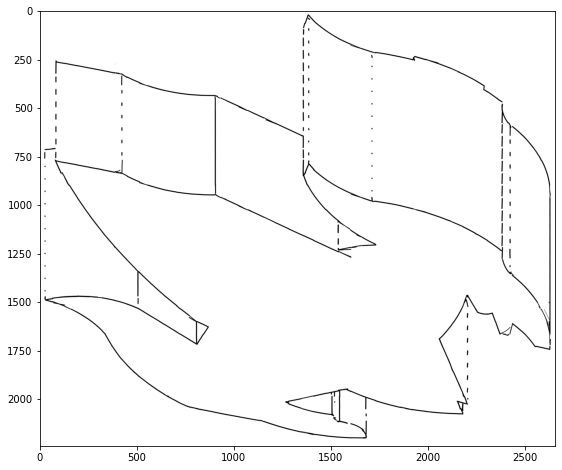

In [28]:
plt.figure(figsize=(12,8))
plt.imshow(rendered_image,"gray")

For some reson model failing to correctly predict vertical lines. One way to correct it, is to slighlty rotate image, another one is to retrain model or refine it on vertical lines.  
P.s. In the paper, all metrics was estimated with this bug, so correcting it may lead to better results.

# Refinement

In [29]:
control_points_n=3
dtype=torch.float32
intermediate_output ={'options':options,'patches_offsets':patches_offsets,
                      'patches_vector':patches_vector,
                      'cleaned_image_shape':(rendered_image.shape[0],rendered_image.shape[1]),
                     'patches_rgb':patches_rgb}


In [30]:
import os
import pickle
import sys
from time import time

import h5py
import numpy as np
import torch
from tqdm import trange


from util_files.optimization.optimizer.logging import Logger
from util_files.evaluation_utils import vector_image_from_patches

from util_files.optimization.optimizer.adam import Adam
from util_files.optimization.primitives.line_tensor import LineTensor
from util_files.optimization.primitives.quadratic_bezier_tensor import QuadraticBezierTensor
from util_files.optimization.parameters import min_linear_size
from util_files.simplification.join_qb import join_quad_beziers
from refinement.our_refinement.refinement_for_curves import main as curve_refinement

In [31]:
primitives_after_optimization, patch__optim_offsets,repatch_scale, optim_vector_image = curve_refinement(options,intermediate_output,optimization_iters_n=200)

2021-06-09 14:33:15,963 INFO: 1. Load intermediate output from /logs/outputs/vectorization/curves//intermediate_output/00050000_99fd5beca7714bc586260b6a_step_000.pickle
2021-06-09 14:33:15,967 INFO: 2.5. Repatch
2021-06-09 14:33:15,971 INFO: 	the width is 5.658815383911133
2021-06-09 14:33:15,971 INFO: 	the width percentile is 90
2021-06-09 14:33:15,972 INFO: 	repatch scale is 3


3
3


2021-06-09 14:33:22,626 INFO: 	168 patches left with max 10 primitives per patch
2021-06-09 14:33:22,626 INFO: 3. Filter out empty patches
2021-06-09 14:33:22,627 INFO: 	from 168 patches
2021-06-09 14:33:22,628 INFO: 	94 patches left
2021-06-09 14:33:22,628 INFO: 3.5. Sort patches
2021-06-09 14:33:22,630 INFO: 	94 patches left with max 10 primitives per patch
2021-06-09 14:33:22,631 INFO: 6. Optimization parameters
2021-06-09 14:33:22,631 INFO: 	primitive type is qbeziers
2021-06-09 14:33:22,633 INFO: 	primitive type of model outputs is qbeziers
2021-06-09 14:33:22,633 INFO: 	initialization is model
2021-06-09 14:33:22,634 INFO: 7. Prepare file with metrics at /logs/outputs/vectorization/curves//200/model_initialization/logs/00050000_99fd5beca7714bc586260b6a_step_000.h5
2021-06-09 14:33:22,636 INFO: 8. Optimization
2021-06-09 14:33:22,638 INFO: Optimize batches:   0%|          | 0/9 [00:00<?, ?it/s]
2021-06-09 14:33:22,638 INFO: 	Initialize
2021-06-09 14:33:22,663 INFO: 	optimize patch

2021-06-09 14:33:30,925 INFO: 	optimize patches 32-46:  31%|###1      | 62/200 [00:02<00:05, 23.74it/s]
2021-06-09 14:33:31,027 INFO: 	optimize patches 32-46:  32%|###2      | 65/200 [00:02<00:05, 25.07it/s]
2021-06-09 14:33:31,155 INFO: 	optimize patches 32-46:  34%|###4      | 69/200 [00:02<00:04, 26.89it/s]
2021-06-09 14:33:31,261 INFO: 	optimize patches 32-46:  36%|###6      | 72/200 [00:02<00:04, 27.25it/s]
2021-06-09 14:33:31,366 INFO: 	optimize patches 32-46:  38%|###7      | 75/200 [00:02<00:04, 27.61it/s]
2021-06-09 14:33:31,468 INFO: 	optimize patches 32-46:  39%|###9      | 78/200 [00:02<00:04, 28.07it/s]
2021-06-09 14:33:31,579 INFO: 	optimize patches 32-46:  40%|####      | 81/200 [00:02<00:04, 27.79it/s]
2021-06-09 14:33:31,710 INFO: 	optimize patches 32-46:  42%|####2     | 85/200 [00:02<00:04, 28.67it/s]
2021-06-09 14:33:31,814 INFO: 	optimize patches 32-46:  44%|####4     | 88/200 [00:03<00:03, 28.71it/s]
2021-06-09 14:33:31,914 INFO: 	optimize patches 32-46:  46%|####

2021-06-09 14:33:40,581 INFO: 	optimize patches 47-57:  66%|######5   | 131/200 [00:04<00:02, 24.94it/s]
2021-06-09 14:33:40,685 INFO: 	optimize patches 47-57:  67%|######7   | 134/200 [00:05<00:02, 25.92it/s]
2021-06-09 14:33:40,789 INFO: 	optimize patches 47-57:  68%|######8   | 137/200 [00:05<00:02, 26.71it/s]
2021-06-09 14:33:40,890 INFO: 	optimize patches 47-57:  70%|#######   | 140/200 [00:05<00:02, 27.58it/s]
2021-06-09 14:33:41,001 INFO: 	optimize patches 47-57:  72%|#######1  | 143/200 [00:05<00:02, 27.40it/s]
2021-06-09 14:33:41,106 INFO: 	optimize patches 47-57:  73%|#######3  | 146/200 [00:05<00:01, 27.72it/s]
2021-06-09 14:33:41,212 INFO: 	optimize patches 47-57:  74%|#######4  | 149/200 [00:05<00:01, 27.88it/s]
2021-06-09 14:33:41,320 INFO: 	optimize patches 47-57:  76%|#######6  | 152/200 [00:05<00:01, 27.90it/s]
2021-06-09 14:33:41,428 INFO: 	optimize patches 47-57:  78%|#######7  | 155/200 [00:05<00:01, 27.85it/s]
2021-06-09 14:33:41,533 INFO: 	optimize patches 47-57: 

2021-06-09 14:33:51,364 INFO: 	optimize patches 58-69:  81%|########1 | 162/200 [00:08<00:01, 21.54it/s]
2021-06-09 14:33:51,498 INFO: 	optimize patches 58-69:  82%|########2 | 165/200 [00:08<00:01, 21.78it/s]
2021-06-09 14:33:51,638 INFO: 	optimize patches 58-69:  84%|########4 | 168/200 [00:08<00:01, 21.69it/s]
2021-06-09 14:33:51,776 INFO: 	optimize patches 58-69:  86%|########5 | 171/200 [00:08<00:01, 21.68it/s]
2021-06-09 14:33:51,910 INFO: 	optimize patches 58-69:  87%|########7 | 174/200 [00:08<00:01, 21.91it/s]
2021-06-09 14:33:52,053 INFO: 	optimize patches 58-69:  88%|########8 | 177/200 [00:08<00:01, 21.59it/s]
2021-06-09 14:33:52,199 INFO: 	optimize patches 58-69:  90%|######### | 180/200 [00:09<00:00, 21.27it/s]
2021-06-09 14:33:52,533 INFO: 	optimize patches 58-69:  92%|#########1| 183/200 [00:09<00:01, 15.08it/s]
2021-06-09 14:33:52,665 INFO: 	optimize patches 58-69:  93%|#########3| 186/200 [00:09<00:00, 16.79it/s]
2021-06-09 14:33:52,810 INFO: 	optimize patches 58-69: 

2021-06-09 14:34:01,460 INFO: 	optimize patches 70-76: 100%|##########| 200/200 [00:08<00:00, 24.54it/s]
2021-06-09 14:34:01,461 INFO: Optimize batches:  56%|#####5    | 5/9 [00:38<00:32,  8.21s/it]
2021-06-09 14:34:01,461 INFO: 	Initialize
2021-06-09 14:34:01,464 INFO: 	optimize patches 77-85:   0%|          | 0/200 [00:00<?, ?it/s]
2021-06-09 14:34:01,867 INFO: 	optimize patches 77-85:   0%|          | 1/200 [00:00<01:20,  2.48it/s]
2021-06-09 14:34:01,967 INFO: 	optimize patches 77-85:   2%|1         | 3/200 [00:00<00:27,  7.06it/s]
2021-06-09 14:34:02,068 INFO: 	optimize patches 77-85:   2%|2         | 5/200 [00:00<00:18, 10.55it/s]
2021-06-09 14:34:02,169 INFO: 	optimize patches 77-85:   4%|3         | 7/200 [00:00<00:14, 13.16it/s]
2021-06-09 14:34:02,319 INFO: 	optimize patches 77-85:   5%|5         | 10/200 [00:00<00:12, 15.72it/s]
2021-06-09 14:34:02,466 INFO: 	optimize patches 77-85:   6%|6         | 13/200 [00:01<00:10, 17.32it/s]
2021-06-09 14:34:02,568 INFO: 	optimize patc

2021-06-09 14:34:13,168 INFO: 	optimize patches 86-90:   5%|5         | 10/200 [00:00<00:09, 20.25it/s]
2021-06-09 14:34:13,274 INFO: 	optimize patches 86-90:   6%|6         | 13/200 [00:00<00:08, 22.76it/s]
2021-06-09 14:34:13,377 INFO: 	optimize patches 86-90:   8%|8         | 16/200 [00:00<00:07, 24.63it/s]
2021-06-09 14:34:13,483 INFO: 	optimize patches 86-90:  10%|9         | 19/200 [00:00<00:07, 25.82it/s]
2021-06-09 14:34:13,597 INFO: 	optimize patches 86-90:  11%|#1        | 22/200 [00:01<00:06, 25.95it/s]
2021-06-09 14:34:13,706 INFO: 	optimize patches 86-90:  12%|#2        | 25/200 [00:01<00:06, 26.43it/s]
2021-06-09 14:34:13,813 INFO: 	optimize patches 86-90:  14%|#4        | 28/200 [00:01<00:06, 26.92it/s]
2021-06-09 14:34:13,919 INFO: 	optimize patches 86-90:  16%|#5        | 31/200 [00:01<00:06, 27.31it/s]
2021-06-09 14:34:14,024 INFO: 	optimize patches 86-90:  17%|#7        | 34/200 [00:01<00:05, 27.69it/s]
2021-06-09 14:34:14,125 INFO: 	optimize patches 86-90:  18%|#8  

2021-06-09 14:34:22,717 INFO: 	optimize patches 91-92:  30%|###       | 61/200 [00:01<00:04, 30.32it/s]
2021-06-09 14:34:22,835 INFO: 	optimize patches 91-92:  33%|###3      | 66/200 [00:01<00:04, 33.16it/s]
2021-06-09 14:34:22,952 INFO: 	optimize patches 91-92:  36%|###5      | 71/200 [00:01<00:03, 35.60it/s]
2021-06-09 14:34:23,064 INFO: 	optimize patches 91-92:  38%|###8      | 76/200 [00:01<00:03, 37.89it/s]
2021-06-09 14:34:23,186 INFO: 	optimize patches 91-92:  40%|####      | 81/200 [00:02<00:03, 38.75it/s]
2021-06-09 14:34:23,305 INFO: 	optimize patches 91-92:  43%|####3     | 86/200 [00:02<00:02, 39.70it/s]
2021-06-09 14:34:23,431 INFO: 	optimize patches 91-92:  46%|####5     | 91/200 [00:02<00:02, 39.72it/s]
2021-06-09 14:34:23,558 INFO: 	optimize patches 91-92:  48%|####8     | 96/200 [00:02<00:02, 39.58it/s]
2021-06-09 14:34:23,687 INFO: 	optimize patches 91-92:  50%|#####     | 101/200 [00:02<00:02, 39.32it/s]
2021-06-09 14:34:23,807 INFO: 	optimize patches 91-92:  53%|###

{'width': '2656px', 'height': '2240px', 'viewBox': '0 0 2656 2240', 'size': ('2656px', '2240px')}


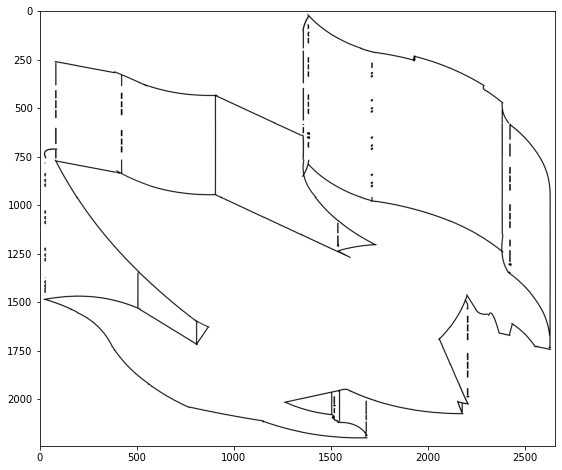

In [32]:
plt.figure(figsize=(12,8))
plt.imshow(optim_vector_image.render(render),"gray")

In [33]:
from merging.merging_for_curves import main as curve_merging

In [34]:
merging_result = curve_merging(options,vector_image_from_optimization=optim_vector_image)

2021-06-09 14:34:32,486 INFO: 3. Simplify curves
2021-06-09 14:34:32,486 INFO: 3. Simplify curves
2021-06-09 14:34:32,489 INFO: 	initial number of lines is 0
2021-06-09 14:34:32,489 INFO: 	initial number of lines is 0
2021-06-09 14:34:32,490 INFO: 	initial number of curves is 244
2021-06-09 14:34:32,490 INFO: 	initial number of curves is 244
2021-06-09 14:34:32,491 INFO: 	width to scale is 7.370446157455445
2021-06-09 14:34:32,491 INFO: 	width to scale is 7.370446157455445
2021-06-09 14:34:32,492 INFO: 	fit_tol is 3.6852230787277227
2021-06-09 14:34:32,492 INFO: 	fit_tol is 3.6852230787277227
2021-06-09 14:34:32,493 INFO: 	w_tol is inf
2021-06-09 14:34:32,493 INFO: 	w_tol is inf
2021-06-09 14:34:32,494 INFO: 	join_tol is 3.6852230787277227
2021-06-09 14:34:32,494 INFO: 	join_tol is 3.6852230787277227
2021-06-09 14:35:57,842 INFO: 	number of curves after merging is 162
2021-06-09 14:35:57,842 INFO: 	number of curves after merging is 162
2021-06-09 14:35:57,869 INFO: 4. Save merging outp

{'width': '2656px', 'height': '2240px', 'viewBox': '0 0 2656 2240', 'size': ('2656px', '2240px')}


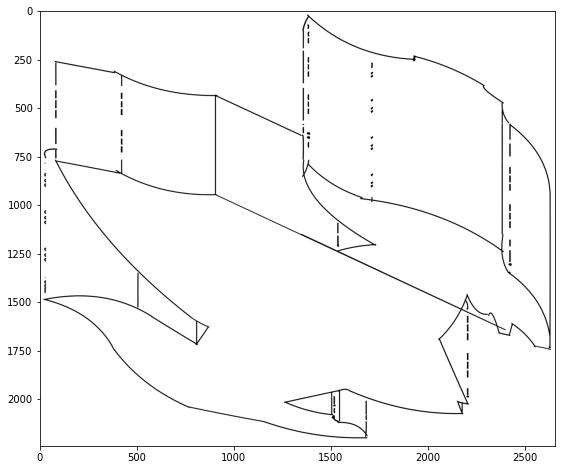

In [35]:
plt.figure(figsize=(12,8))
plt.imshow(merging_result.render(render),'gray')